In [134]:
import numpy as np
import glob
import pandas as pd
import geopandas as gpd
import xarray as xr
import os.path as osp
from matplotlib import pyplot as plt
from geopy.distance import geodesic
from shapely import geometry
import networkx as nx
from matplotlib import cm

In [182]:
dp = '/home/fiona/birdMigration/data/raw/radar/fall/2015'
files = glob.glob(osp.join(dp, '*.nc'))
data = {}
start = f'2015-08-15 18:00:00'
end = f'2015-11-15 18:00:00'
for f in files:
    ds = xr.open_dataset(f)
    radar = ds.source
    radar = (radar[:2]+radar[-3:]).lower()
    data[radar] = ds.sel(time=slice(start, end)).resample(time='1H', skipna=True).reduce(np.nanmean)

/home/fiona/anaconda3/lib/python3.7/site-packages/xarray/core/variable.py:1535: RuntimeWarning: Mean of empty slice
  data = func(input_data, axis=axis, **kwargs)
/home/fiona/anaconda3/lib/python3.7/site-packages/xarray/core/variable.py:1535: RuntimeWarning: Mean of empty slice
  data = func(input_data, axis=axis, **kwargs)
/home/fiona/anaconda3/lib/python3.7/site-packages/xarray/core/variable.py:1535: RuntimeWarning: Mean of empty slice
  data = func(input_data, axis=axis, **kwargs)
/home/fiona/anaconda3/lib/python3.7/site-packages/xarray/core/variable.py:1535: RuntimeWarning: Mean of empty slice
  data = func(input_data, axis=axis, **kwargs)
/home/fiona/anaconda3/lib/python3.7/site-packages/xarray/core/variable.py:1535: RuntimeWarning: Mean of empty slice
  data = func(input_data, axis=axis, **kwargs)
/home/fiona/anaconda3/lib/python3.7/site-packages/xarray/core/variable.py:1535: RuntimeWarning: Mean of empty slice
  data = func(input_data, axis=axis, **kwargs)
/home/fiona/anaconda3/

In [96]:
def compute_flux(dens, ff, dd, alpha, l):
    # compute number of birds crossing transect of length 'l' [km] and angle 'alpha' per hour
    mtr = dens * ff * np.cos(np.deg2rad(dd - alpha))
    flux = mtr * l * 3.6
    return flux

def compute_angle(coord1, coord2):
    # coords should be in lonlat crs
    y = coord2[0] - coord1[0]
    x = coord2[1] - coord1[1]

    rad = np.arctan2(y, x)
    deg = np.rad2deg(rad)
    deg = (deg + 360) % 360

    return deg

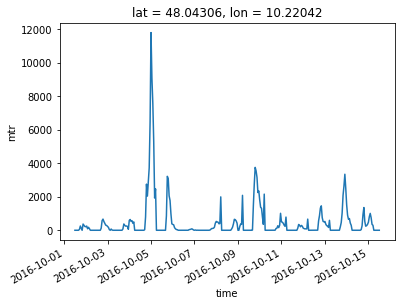

In [104]:
data['demem'].mtr.plot()

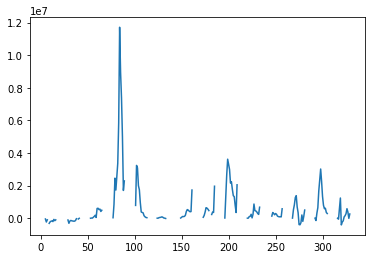

In [105]:
ds = data['demem']
fluxes = compute_flux(ds.vid.values, ds.ff.values, ds.dd.values, 230, 1000)
plt.plot(fluxes.flatten())

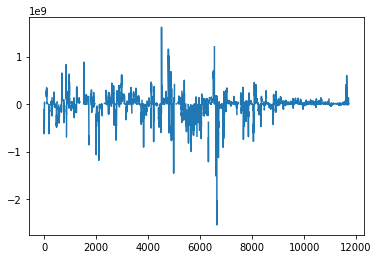

In [24]:
ds = data['DE/MEM']
fluxes = compute_flux(ds.vid.values, ds.ff.values, ds.dd.values, 140, 1000)
plt.plot(fluxes.flatten())

In [169]:
voronoi = gpd.read_file('/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=15/radar/fall/2016/voronoi.shp')
G_path = '/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=15/radar/fall/2016/delaunay.gpickle'
G = nx.read_gpickle(G_path)

In [170]:
G_new = nx.DiGraph()
G_new.add_nodes_from(list(G.nodes(data=True)))

for i, j, e_data in G.edges(data=True):
    ri = G.nodes[i]['radar']
    rj = G.nodes[j]['radar']
    angle = e_data['angle']
    length = e_data['face_length']
    
    if ri in data and not rj in data:
        dsi = data[ri]
        dsj = data[ri]
    elif ri not in data and rj in data:
        dsi = data[rj]
        dsj = data[rj]
    elif ri in data and rj in data:
        dsi = data[ri]
        dsj = data[rj]
    else:
        continue

    T = 5
    if len(dsi.vid) == len(dsj.vid):
        vid_interp = (dsi.vid.values.flatten() + dsj.vid.values.flatten()) / 2
        dd_interp = ((dsi.dd.values.flatten() + 360) % 360 + (dsj.dd.values.flatten() + 360) % 360) / 2
        ff_interp = (dsi.ff.values.flatten() + dsj.ff.values.flatten()) / 2
        flux_i = compute_flux(dsi.vid.values, dsi.ff.values, (dsi.dd.values + 360) % 360, angle, length).flatten()[:T]
        flux_j = compute_flux(dsj.vid.values, dsj.ff.values, (dsj.dd.values + 360) % 360, angle, length).flatten()[:T]

        flux_interp  = np.nanmean(compute_flux(vid_interp, ff_interp, dd_interp, angle, length))
        if flux_interp > 0:
            G_new.add_edge(i, j, flux=flux_interp)

#         print((i, j), angle, flux_i, flux_j)
#         print((i, j), angle, flux_interp, (flux_i + flux_j)/2)
#         print((i, j), (dsi.dd.values.flatten()[:T] + 360) % 360, (dsj.dd.values.flatten()[:T] + 360) % 360)
#         print((i, j), dsi.ff.values.flatten()[:T], dsj.ff.values.flatten()[:T])

        

/home/fiona/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in remainder
/home/fiona/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in remainder
/home/fiona/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in remainder


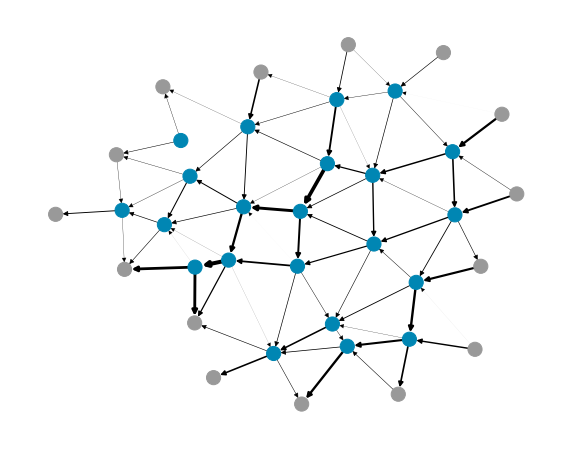

In [171]:
pos = {ridx:(voronoi.query(f'radar == "{name}"').x.values[0], voronoi.query(f'radar == "{name}"').y.values[0]) for (ridx, name) in nx.get_node_attributes(G_new, 'radar').items()}
cmap = cm.get_cmap('YlOrBr')
edge_widths = np.array(list(nx.get_edge_attributes(G_new,'flux').values()))
edge_widths /= 0.25 * edge_widths.max()
node_colors = ['#999999' if 'boundary' in n_data['radar'] else '#0086b3' for n, n_data in G_new.nodes(data=True)]
fig, ax = plt.subplots(figsize=(10,8))
options = {
    'arrowsize': 30,
}
nx.draw(G_new, pos=pos, with_labels=False, node_size=200, node_color=node_colors, width=edge_widths, ax=ax, options={'arrowsize': edge_widths*100})

In [178]:
total_fluxes = {n : 0 for n in G_new.nodes()}
for i, j, e in G_new.edges(data=True):
    total_fluxes[i] -= e['flux'] / 6549825
    total_fluxes[j] += e['flux'] / 6549825

In [180]:
for n, data in G_new.nodes(data=True):
    print(data['radar'], total_fluxes[n])

nldbl -0.0003247331512674003
bezav 0.0017007820745091472
bejab 0.00022593593268713295
deess 0.0002979343337413669
deemd 0.002510659389933605
nldhl -0.002192779169553194
boundary_0 0.0013998063790110807
dehnr -0.0035987880043550783
defld 0.0007911084754649929
deboo -0.0038620021127711425
deumd -0.0019311082574844562
deneu 0.001384899760561351
deeis -0.001755741493861179
dedrs 0.0010241809597489257
deoft 0.0007608145820216482
detur 0.00038947199179701416
depro -9.135278065635385e-05
deros -0.001641309136185324
boundary_5 -0.005798689148895289
boundary_6 -0.005759727180210922
denhb -0.0036112032782125857
bewid -0.0042729755847782675
boundary_13 0.00927691002538713
boundary_14 0.0023945639172611483
boundary_3 -0.0025035899322095436
boundary_4 -0.0016139197003832164
deisn -0.00045777787807069203
boundary_7 -0.0040597011418244
boundary_8 -0.0037530880747007676
defbg 0.0009035706099196823
boundary_12 0.012113428364498288
boundary_2 -0.00359908549113192
boundary_1 0.0013845291414632261
demem -